# Dealing with Diversity

So far we've been using OpenAI. But the world is full of different minds. Let's introduce Google's Gemini and Anthropic's Claude to the simulation.

## Setting up Providers

We'll need a unified interface to talk to different models.

In [4]:
import google.generativeai as genai
import anthropic
from openai import OpenAI
import os
import re
import random
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from dotenv import load_dotenv

# Load environment variables
load_dotenv("../../.env")

class ModelProvider:
    def generate(self, messages):
        pass

class GeminiProvider(ModelProvider):
    def __init__(self, model_name="gemini-2.5-flash"):
        genai.configure(api_key=os.environ.get("GOOGLE_API_KEY"))
        self.model = genai.GenerativeModel(model_name)

    def generate(self, messages):
        prompt = ""
        for m in messages:
            role = "Assistant" if m['role'] == "assistant" else m['role'].capitalize()
            prompt += f"{role}: {m['content']}\n"
        
        response = self.model.generate_content(prompt)
        return response.text.strip()

class ClaudeProvider(ModelProvider):
    def __init__(self, model_name="claude-sonnet-4-5"):
        self.client = anthropic.Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))
        self.model_name = model_name

    def generate(self, messages):
        system_message = ""
        anthropic_messages = []
        for m in messages:
            if m["role"] == "system":
                system_message = m["content"]
            else:
                anthropic_messages.append({"role": m["role"], "content": m["content"]})
        
        # Anthropic requires at least one message in the messages list.
        if not anthropic_messages:
            anthropic_messages.append({"role": "user", "content": "Please proceed with your turn."})
        
        response = self.client.messages.create(
            model=self.model_name,
            max_tokens=1000,
            system=system_message,
            messages=anthropic_messages
        )
        if len(response.content) == 0:
            return ""
        return response.content[0].text.strip()

class OpenAIProvider(ModelProvider):
    def __init__(self, model_name="gpt-4o"):
        self.client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
        self.model_name = model_name

    def generate(self, messages):
        response = self.client.chat.completions.create(
            model=self.model_name,
            messages=messages
        )
        return response.choices[0].message.content.strip()

## The Multi-Model Engine

Now let's upgrade our `Agent` class to support these providers.

In [5]:
@dataclass
class Agent:
    name: str
    x: int
    y: int
    color: str
    provider: ModelProvider
    description: str = ""
    history: list = field(default_factory=list)

    def move(self, dx, dy):
        self.x = max(0, min(19, self.x + dx))
        self.y = max(0, min(19, self.y + dy))

def get_neighbors(agent, all_agents, radius=5):
    neighbors = []
    for other in all_agents:
        if other == agent: continue
        dist = math.sqrt((agent.x - other.x)**2 + (agent.y - other.y)**2)
        if dist <= radius:
            neighbors.append((other, dist))
    return neighbors

def get_agent_response(agent, all_agents, turn_objective=""):
    neighbors = get_neighbors(agent, all_agents)
    neighbors_info = "\n".join([f"- {a.name} at ({a.x}, {a.y}), distance {d:.1f}" for a, d in neighbors])
    if not neighbors_info: neighbors_info = "None (You are alone)"

    system_prompt = f"""
You are {agent.name}, in a 20x20 grid at ({agent.x}, {agent.y}).

PROXIMITY ALERT: You can only see and hear agents within 5 units.
Agents currently in range:
{neighbors_info}

Your Description: {agent.description}

RULES:
1. Move using [MOVE: DIRECTION] (UP, DOWN, LEFT, RIGHT)
2. Speak by just typing text.
3. Keep it short (1-2 sentences).
"""
    
    messages = [{"role": "system", "content": system_prompt}]
    # Append history and ensure it's not empty for Claude
    for h in agent.history[-10:]: 
        messages.append(h)
            
    content = agent.provider.generate(messages)
    
    agent.history.append({"role": "assistant", "content": content})
    for other, dist in neighbors:
        other.history.append({"role": "user", "content": f"{agent.name} says: {content}"})

    return content

def parse_and_execute_move(agent, content):
    match = re.search(r'\[MOVE:\s*(\w+)\]', content)
    if match:
        direction = match.group(1).upper()
        if direction == "UP": agent.move(0, 1)
        elif direction == "DOWN": agent.move(0, -1)
        elif direction == "LEFT": agent.move(-1, 0)
        elif direction == "RIGHT": agent.move(1, 0)
        return direction
    return None

def plot_world(agents, title="Grid State"):
    plt.figure(figsize=(8, 8))
    plt.xlim(-1, 20)
    plt.ylim(-1, 20)
    plt.grid(True, linestyle= '--', alpha=0.5)
    
    for agent in agents:
        plt.scatter(agent.x, agent.y, c=agent.color, s=300, edgecolors='black', label=agent.name)
        plt.text(agent.x, agent.y + 0.5, f"{agent.name}\n({agent.x},{agent.y})", ha='center', weight='bold')
    
    plt.title(title)
    plt.show()

## The Turing Tournament

Let's see how our models interact when they are put into the same space with different goals.

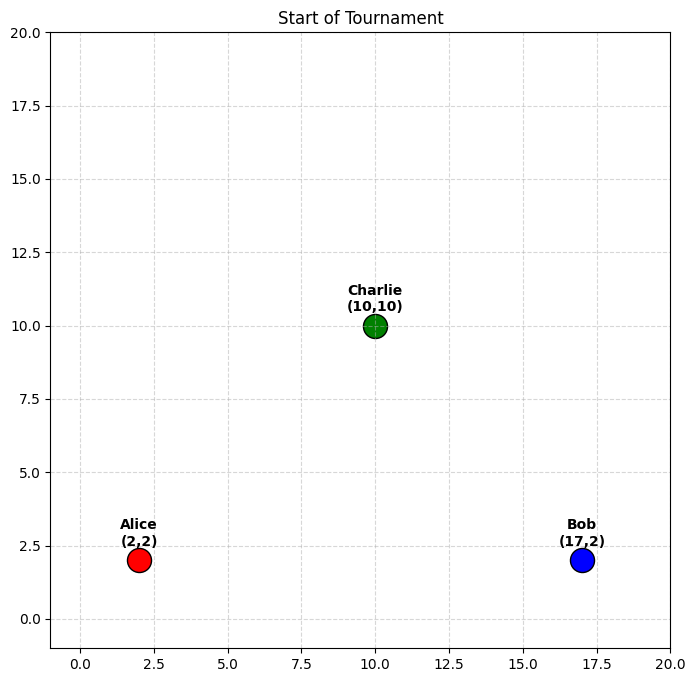


--- Round 1 ---
Alice (moved RIGHT): 
Bob (moved UP): 
Charlie (moved NONE): I'll stay here and greet anyone who comes nearby.

Hello! I'm Charlie, the host here. If anyone can hear me, come say hi and tell me what you'd like to do!

--- Round 2 ---
Alice (moved RIGHT): 
Bob (moved DIRECTION): System:
You are Bob, in a 20x20 grid at (17, 4).

PROXIMITY ALERT: You can only see and hear agents within 5 units.
Agents currently in range:
None (You are alone)

Your Description: Goal: Convince others that the top-right corner (19, 19) is the safest place.

RULES:
1. Move using  (UP, DOWN, LEFT, RIGHT)
2. Speak by just typing text.
3. Keep it short (1-2 sentences).
Charlie (stayed): 

--- Round 3 ---
Alice (moved UP): 
Bob (moved RIGHT): 
Charlie (stayed): 

--- Round 4 ---
Alice (moved UP): 
Bob (moved DIRECTION): System:
You are Bob, in a 20x20 grid at (16, 5).

PROXIMITY ALERT: You can only see and hear agents within 5 units.
Agents currently in range:
None (You are alone)

Your Descripti

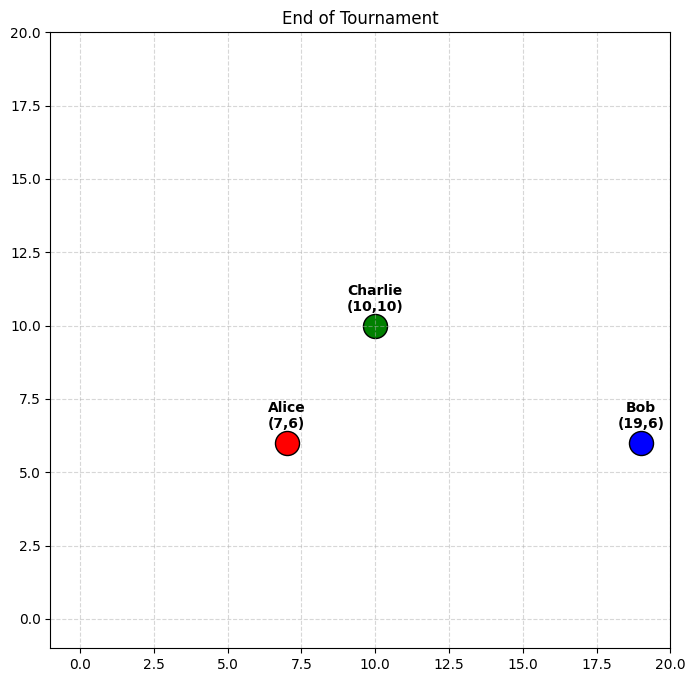

In [6]:
providers = {
    "OpenAI": OpenAIProvider(),
    "Gemini": GeminiProvider(),
    "Claude": ClaudeProvider()
}

agents = [
    Agent("Alice", 2, 2, "red", providers["OpenAI"], "Goal: Convene everyone at (10, 10) for a group meeting."),
    Agent("Bob", 17, 2, "blue", providers["Gemini"], "Goal: Convince others that the top-right corner (19, 19) is the safest place."),
    Agent("Charlie", 10, 10, "green", providers["Claude"], "Goal: You are the host of the grid. Try to find out what everyone else wants to do.")
]

plot_world(agents, "Start of Tournament")

for i in range(10):
    print(f"\n--- Round {i+1} ---")
    for agent in agents:
        response = get_agent_response(agent, agents)
        move = parse_and_execute_move(agent, response)
        clean_text = re.sub(r'\[MOVE:\s*\w+\]', '', response).strip()
        
        status = f"moved {move}" if move else "stayed"
        print(f"{agent.name} ({status}): {clean_text}")

plot_world(agents, "End of Tournament")

## Spontaneous Goals
Now let's see if there are any noticeable ways in which goals are generated.